In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import io
import os
import sys
import torch
import timm
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.transforms as transforms
import albumentations as alb
import torch.multiprocessing as mp
import gc
import wandb
from torchvision.transforms import v2
from lightning.pytorch.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.nn.functional import cross_entropy
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')


In [241]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [242]:
import cv_split_utils
import dl_utils
import loss_functions

In [243]:
class ImgStats:
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]    

class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"
    EFFNET_B0 = "tf_efficientnet_b0_ns"
    EFFNET_B4 = "tf_efficientnet_b4_ns"

class Config:
    RUNTIME = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    NUM_CLASSES = 2
    BATCH_SIZE = 16
    NUM_WORKERS = mp.cpu_count()
    NUM_EPOCHS = 2
    IMG_MEAN = ImgStats.IMAGENET_MEAN
    IMG_STD = ImgStats.IMAGENET_STD
    UNFREEZE_EPOCH_NO = 2
    PRECISION = "16-mixed"
    PATIENCE = 6
    LOG_EVERY_N_STEPS = 10
    MODEL_TO_USE = Models.RESNET50
    WEIGHT_DECAY = 1e-6
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    # model hyperparameters
    MODEL_PARAMS = {    
        "drop_out": 0.25,
        "lr": 0.005,
        "warmup_prop": 0.05
    }        
    INPUT_IMAGE_SIZE = (128,128)
    TARGET_COL_NAME = "target"
    SUBSET_ROWS_FRAC = 0.001    
    FINE_TUNE = True
    FAST_DEV_RUN = False

class SchedulerConfig:
    SCHEDULER_PATIENCE = 3
    SCHEDULER = "ReduceLROnPlateau"
    T_0 = 10 # for CosineAnnealingWarmRestarts
    MIN_LR = 5e-7 # for CosineAnnealingWarmRestarts
    MAX_LR = 1e-2
    STEPS_PER_EPOCH = 13 # for OneCycleLR

class WandbConfig:
    WANDB_KEY = "c5e2877bf080e6b62fcc57231c91e3a1455f97d0"
    WANDB_RUN_NAME = "pl_cnn_signs_resnet50"
    WANDB_PROJECT = "pl_cnn_signs"
    USE_WANDB = False        

In [244]:
if Config.RUNTIME == "COLAB":
    Config.DATA_ROOT_FOLDER = "/content/gdrive/MyDrive/Kaggle/Pog_Music_Classification/data/"    
elif Config.RUNTIME == "KAGGLE":
    Config.DATA_ROOT_FOLDER = "/content/gdrive/MyDrive/Kaggle/Pog_Music_Classification/data/"    
else:
    Config.DATA_ROOT_FOLDER = "./data/"    

In [245]:
def config_to_dict(cfg):
    # dir is an inbuilt python function that returns the list of attributes and methods of any object
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [246]:
config_dict = config_to_dict(Config)
schd_config_dict = config_to_dict(SchedulerConfig)
merged_config_dict = {**config_dict, **schd_config_dict}

In [247]:
# write a function to ensure config_dict dictionary has all the required keys, print the names of missing keys
# if any. Also raise an error if any of the required keys are missing
def check_config_dict(config_dict, keys_to_check):
    missing_keys = []
    for key in keys_to_check:
        if key not in config_dict:
            missing_keys.append(key)
    if len(missing_keys) > 0:
        raise ValueError(f"Missing keys in config_dict: {missing_keys}")    
    
check_config_dict(merged_config_dict, ["MODEL_TO_USE", "NUM_CLASSES", "MODEL_PARAMS", "FINE_TUNE"])

In [248]:
df_train_metadata = pd.read_csv(Config.DATA_ROOT_FOLDER + "train-metadata.csv")

In [249]:
df_train_pos = df_train_metadata[df_train_metadata["target"] == 1]
df_train_neg = df_train_metadata[df_train_metadata["target"] == 0]

if Config.SUBSET_ROWS_FRAC is not None:
    train_rows_count = df_train_metadata.shape[0]    
    df_train_neg = df_train_neg.sample(frac=Config.SUBSET_ROWS_FRAC, random_state=Config.RANDOM_SEED).reset_index(drop=True)
    print(f"Selecting {Config.SUBSET_ROWS_FRAC * 100}% negative samples equal to {len(df_train_neg)} rows")

print(f"Selecting 100% positive samples equal to {len(df_train_pos)} rows")
df_train_metadata = pd.concat([df_train_pos, df_train_neg], axis=0).sample(frac=1, random_state=Config.RANDOM_SEED).reset_index(drop=True)

Selecting 0.1% negative samples equal to 401 rows
Selecting 100% positive samples equal to 393 rows


In [250]:
df_train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_3242979,0,IP_1225710,60.0,male,posterior torso,4.12,TBP tile: close-up,3D: XP,18.049568,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,86.687905
1,ISIC_4194770,0,IP_3026693,75.0,female,lower extremity,4.06,TBP tile: close-up,3D: white,20.153902,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.997663
2,ISIC_1377023,1,IP_9781727,20.0,female,head/neck,7.33,TBP tile: close-up,3D: white,18.768670,...,IL_7419475,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,NaN,NaN,NaN,NaN,81.006060
3,ISIC_6305916,0,IP_9978624,55.0,female,anterior torso,4.52,TBP tile: close-up,3D: white,19.817210,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,83.082440
4,ISIC_1621074,1,IP_6321403,60.0,male,upper extremity,1.10,TBP tile: close-up,3D: XP,13.687050,...,IL_5025970,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma Invasive,"Melanoma Invasive, Superficial spreading",NaN,0/mm^2,0.4,99.993440


In [251]:
# We need to ensure the same group (patient_id) doesn't appear both in train and validation set. Also we need to ensure
# class distribution is maintained
df_train_metadata = cv_split_utils.strat_group_kfold_dataframe(
                        df=df_train_metadata, 
                        target_col_name=Config.TARGET_COL_NAME, 
                        group_col_name="patient_id",
                        random_state=Config.RANDOM_SEED, 
                        num_folds=Config.NUM_FOLDS
                    )

In [252]:
class ISICHDF5Dataset(Dataset):
    def __init__(self, hdf5_file_path, df, target_col, transform=None, target_transform=None):
        # image medatadata dataframe
        self.df = df
        self.hdf5_file_path = hdf5_file_path        
        self.target_col = target_col
        self.transform = transform
        self.target_transform = target_transform
        with h5py.File(hdf5_file_path, "r") as f:
            self.keys = list(f.keys())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # idx is the index of the image in the hdf5 file which is the same as index in the image metadata dataframe.         
        img_label = self.df.loc[idx, self.target_col]
        img_id = self.df.loc[idx, "isic_id"]
        patient_id = self.df.loc[idx, "patient_id"]
        with h5py.File(self.hdf5_file_path, "r") as f:
            key = self.keys[idx]
            dataset = f[key]
            # the dataset is scalar i.e. contains only a single element which is image byte data in string format
            # To retrieve the single element from dataset we need to use the following code
            image_byte_data = dataset[()]
            img = Image.open(io.BytesIO(image_byte_data))
            img_arr = np.array(img)
            if self.transform:
                augmented = self.transform(image=img_arr)
                img_arr = augmented["image"]
            if self.target_transform is not None:
                img_label = self.target_transform(img_label)
            return img_id, patient_id, img_arr, img_label

In [253]:
train_transform = alb.Compose([
        alb.Resize(224, 224),
        #alb.RandomResizedCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),        
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        alb.Flip(p=0.5),
        alb.Downscale(p=0.25),
        alb.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        alb.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        alb.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()
])
val_transform = alb.Compose([
        alb.Resize(224, 224),
        #alb.CenterCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()
])

In [254]:
my_df_val = df_train_metadata[df_train_metadata.kfold == 0]
len(my_df_val[my_df_val["target"] == 1]) / len(my_df_val)

0.42592592592592593

In [255]:
def get_fold_dls(fold, df_img_metadata, hdf5_file_path):
    df_train = df_img_metadata[df_img_metadata["kfold"] != fold].reset_index(drop=True)
    df_val = df_img_metadata[df_img_metadata["kfold"] == fold].reset_index(drop=True)    
    train_pos_ratio = round(len(df_train[df_train["target"] == 1]) / len(df_train), 2)
    val_pos_ratio = round(len(df_val[df_val["target"] == 1]) / len(df_val), 2)
    print(f"Fold {fold}: {df_train.shape[0]} train, {train_pos_ratio} train positive ratio - "
          f"{df_val.shape[0]} val, {val_pos_ratio} val positive ratio")
    ds_train = ISICHDF5Dataset(
        hdf5_file_path=hdf5_file_path, 
        df=df_train,
        target_col=Config.TARGET_COL_NAME,        
        transform=train_transform,
        target_transform=torch.as_tensor
    )
    ds_val = ISICHDF5Dataset(
        hdf5_file_path=hdf5_file_path, 
        df=df_val,
        target_col=Config.TARGET_COL_NAME,        
        transform=val_transform,
        target_transform=torch.as_tensor
    )
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)    
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [256]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(fig_size, img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=fig_size)
    # select num_items random indexes from the dataset
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        _, _, img, lb = img_ds[img_index]            
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):            
            ax.imshow(Image.fromarray(np.uint8(img)).convert('RGB'))        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

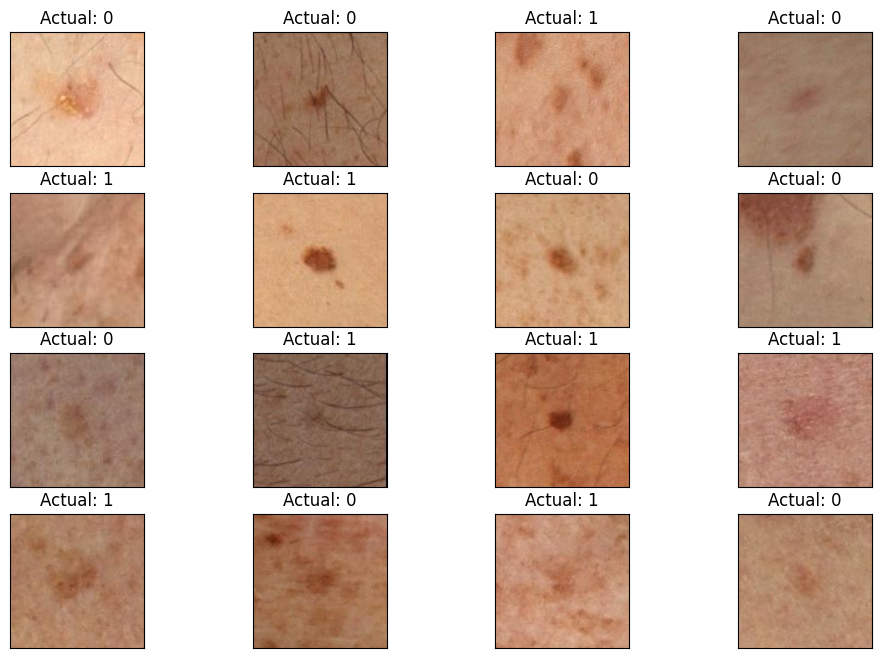

In [257]:
isic_img_ds_display = ISICHDF5Dataset(
    hdf5_file_path=Config.DATA_ROOT_FOLDER+"train-image.hdf5",
    df=df_train_metadata,
    target_col=Config.TARGET_COL_NAME
)
show_batch(fig_size=(12,8), img_ds=isic_img_ds_display, num_items=16, num_rows=4, num_cols=4)

In [258]:
class ISIC_LitModel(pl.LightningModule):
    def __init__(self, config_dict):
        super().__init__()
        self.config_dict = config_dict
        self.lr = config_dict["MODEL_PARAMS"]["lr"]
        self.drop_out = config_dict["MODEL_PARAMS"]["drop_out"]        
        self.model = timm.create_model(config_dict["MODEL_TO_USE"], pretrained=True)
        self.cutmix = v2.CutMix(num_classes=config_dict["NUM_CLASSES"])
        self.mixup = v2.MixUp(num_classes=config_dict["NUM_CLASSES"])
        self.cutmix_or_mixup = v2.RandomChoice([self.cutmix, self.mixup])
        if not config_dict["FINE_TUNE"]:
            if config_dict["MODEL_TO_USE"] in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, config_dict["NUM_CLASSES"])
            elif config_dict["MODEL_TO_USE"] in [Models.EFFNET_B0, Models.EFFNET_B4]:
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, config_dict["NUM_CLASSES"])
        else:        
            self.backbone, self.classifier = self.get_backbone_classifier(
                model_to_use=config_dict["MODEL_TO_USE"], 
                drop_out=self.drop_out, 
                num_classes=config_dict["NUM_CLASSES"]
            ) 

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )
        if model_to_use in [Models.EFFNET_B0, Models.EFFNET_B4]:
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.classifier.in_features
            classifier = nn.Linear(in_features, num_classes)                    
        return backbone, classifier        
    
    def forward(self, x):
        if Config.FINE_TUNE:
            features = self.backbone(x)
            features = torch.flatten(features, 1)                
            x = self.classifier(features)
        else:
            x = self.model(x)        
        return x

    def configure_optimizers(self):                
        return dl_utils.get_optimizer(lr=self.lr, params=self.parameters(), config_dict=self.config_dict)    
    
    def training_step(self, batch, batch_idx):
        _, _, X, y = batch
        self.cutmix_or_mixup = v2.RandomChoice([self.cutmix, self.mixup])
        X, y = self.cutmix_or_mixup(X, y)                
        y_pred = self(X)
        loss = cross_entropy(y_pred, y)
        # convert y that is one hot encoded back to 0 and 1
        y = torch.argmax(y, dim=1)
        # convert y and y_pred to numpy arrays
        y = y.detach().cpu().numpy()                
        y_pred = torch.sigmoid(y_pred)[:, 1].detach().cpu().numpy()                
        train_p_auc = loss_functions.partial_auc(y_pred, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_partial_auc", train_p_auc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        _, _, X, y = batch
        y_pred = self(X)
        val_loss = cross_entropy(y_pred, y)
        # convert y and y_pred to numpy arrays
        y = y.detach().cpu().numpy()
        y_pred = torch.sigmoid(y_pred)[:, 1].detach().cpu().numpy()        
        val_p_auc = loss_functions.partial_auc(y_pred, y)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_partial_auc", val_p_auc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("cur_lr", current_lr, prog_bar=True, on_step=True, on_epoch=True, logger=True)
        return {"loss": val_loss, "val_partial_auc": val_p_auc}

In [259]:
# For results reproducibility 
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
pl.seed_everything(Config.RANDOM_SEED, workers=True)

Seed set to 42


42

In [260]:
def run_training(fold, dl_train, dl_val, find_lr=True):
    try:
        fold_str = f"fold{fold}"
        print(f"Running training for {fold_str}")
        logger = None
        if WandbConfig.USE_WANDB:                
            logger = dl_utils.get_wandb_logger(fold, merged_config_dict)
        print("Instantiated wandb logger")    
        chkpt_file_name = "best_model_{epoch}_{val_loss:.4f}"        
        multiplicative = lambda epoch: 1.5
        backbone_finetuning = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=True)
        early_stopping_callback = EarlyStopping(monitor="val_loss", patience=Config.PATIENCE, mode="min", verbose=True)
        if fold is not None:       
            chkpt_file_name = fold_str + "_" + chkpt_file_name
        isic_model = ISIC_LitModel(config_dict=merged_config_dict)    
        loss_chkpt_callback = ModelCheckpoint(dirpath="./model", verbose=True, monitor="val_loss", mode="min", filename=chkpt_file_name)
        pauc_chkpt_callback = dl_utils.MetricsAggCallback(metric_to_monitor="val_partial_auc", mode="max")
        trainer = pl.Trainer(
            devices="auto",
            accelerator="gpu",
            # For results reproducibility 
            deterministic=True,
            strategy="auto",
            log_every_n_steps=Config.LOG_EVERY_N_STEPS,
            max_epochs=Config.NUM_EPOCHS,        
            precision=Config.PRECISION,   
            enable_model_summary=True,
            enable_progress_bar=True,                        
            logger=logger,
            fast_dev_run=Config.FAST_DEV_RUN,            
            callbacks=[loss_chkpt_callback, pauc_chkpt_callback, backbone_finetuning, early_stopping_callback]
        )
        tuner = Tuner(trainer)
        
        if find_lr:
            lr_finder = tuner.lr_find(model=isic_model, train_dataloaders=dl_train)
            # Results can be found in
            print(lr_finder.results)
            # Results can be plotted to identify the optimal learning rate
            fig = lr_finder.plot(suggest=True)
            fig.show()
            # Pick the suggested learning rate
            new_lr = lr_finder.suggestion()
            print(f"new_lr = {new_lr}")

        trainer.fit(isic_model, train_dataloaders=dl_train, val_dataloaders=dl_val)                
        loss = loss_chkpt_callback.best_model_score.detach().cpu().item()
        p_auc = pauc_chkpt_callback.best_metric
        print(f"Loss for {fold_str} = {loss}, partial auc = {p_auc}")
        del trainer, tuner, isic_model, backbone_finetuning, early_stopping_callback, pauc_chkpt_callback, loss_chkpt_callback
        return loss, p_auc
    except KeyboardInterrupt as e:
        wandb.finish(exit_code=-1, quiet=True)
        print("Marked the wandb run as failed")
    finally:
        gc.collect()
        torch.cuda.empty_cache()
        wandb.finish()

In [261]:
find_lr = True
fold_loss = []
fold_p_auc = []

for fold in range(Config.NUM_FOLDS):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, 
                                                      df_img_metadata=df_train_metadata, 
                                                      hdf5_file_path=Config.DATA_ROOT_FOLDER+"train-image.hdf5")
    loss, p_auc = run_training(fold, dl_train, dl_val, find_lr=False)
    fold_loss.append(loss)
    fold_p_auc.append(p_auc)
    break
     

Fold 0: 632 train, 0.51 train positive ratio - 162 val, 0.43 val positive ratio
Running training for fold0
Instantiated wandb logger


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU av

param groups count = 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

epoch = 1 => metric val_partial_auc = 0.07500000298023224, val_loss=0.6671295166015625, lr=0.004999999888241291


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.756
INFO: Epoch 0, global step 40: 'val_loss' reached 0.75631 (best 0.75631), saving model to '/home/bk_anupam/code/ML/KaggleChallenges/CV/ISIC2024/model/fold0_best_model_epoch=0_val_loss=0.7563.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 40: 'val_loss' reached 0.75631 (best 0.75631), saving model to '/home/bk_anupam/code/ML/KaggleChallenges/CV/ISIC2024/model/fold0_best_model_epoch=0_val_loss=0.7563.ckpt' as top 1


epoch = 2 => metric val_partial_auc = 0.04597919434309006, val_loss=0.7563069462776184, lr=0.004999999422580004


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 80: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 80: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


epoch = 3 => metric val_partial_auc = 0.05034427344799042, val_loss=0.8900432586669922, lr=0.004999999422580004
Loss for fold0 = 0.7563069462776184, partial auc = 0.07500000298023224
